In [35]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from biosppy.signals import ecg

# Set the directory where your PhysioNet data is stored
df = pd.read_csv('data/mit-bih/compiled_mit_bih.csv')

# Given
frequency = 360

<Figure size 1500x1500 with 0 Axes>

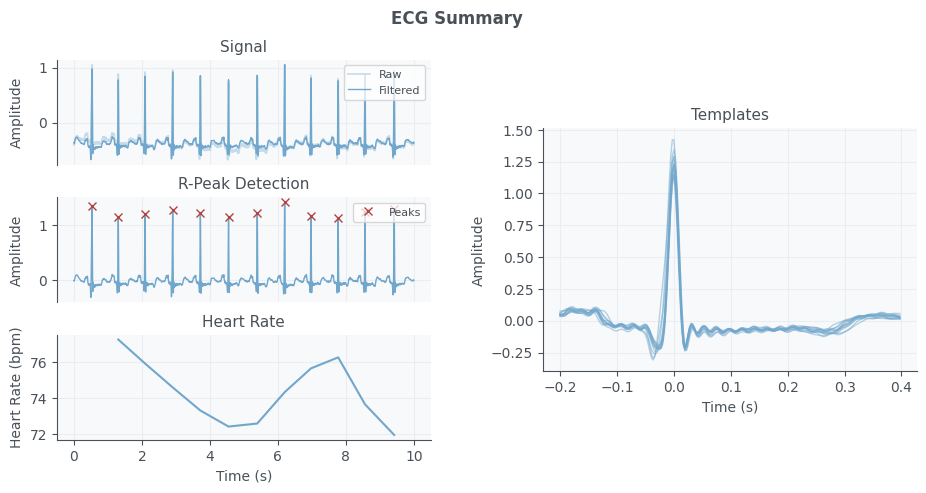

Available outputs: ['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']


In [36]:
# Test the function with a single record

record_name = 1

plt.figure(figsize=(15, 15))
all_signals = df.drop(columns=['label']).values

ecg_signal = all_signals[record_name]
out = ecg.ecg(signal=ecg_signal, sampling_rate=frequency, show=True)
# Print all available keys
print("Available outputs:", out.keys())


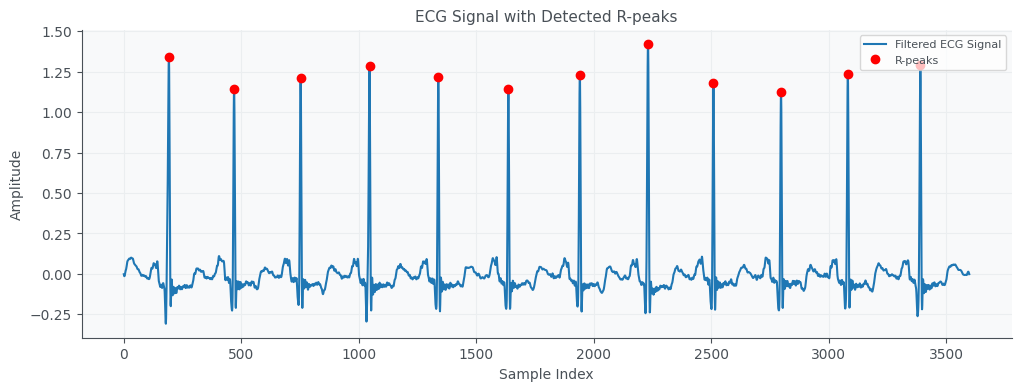

In [37]:
# Extract the processed signal and R-peak locations
filtered_ecg = out['filtered']
r_peaks = out['rpeaks']

# Plot the ECG signal with R-peaks
plt.figure(figsize=(12, 4))
plt.plot(filtered_ecg, label="Filtered ECG Signal")
plt.plot(r_peaks, filtered_ecg[r_peaks], "ro", label="R-peaks")  # Mark R-peaks with red dots
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-peaks")
plt.legend()
plt.show()

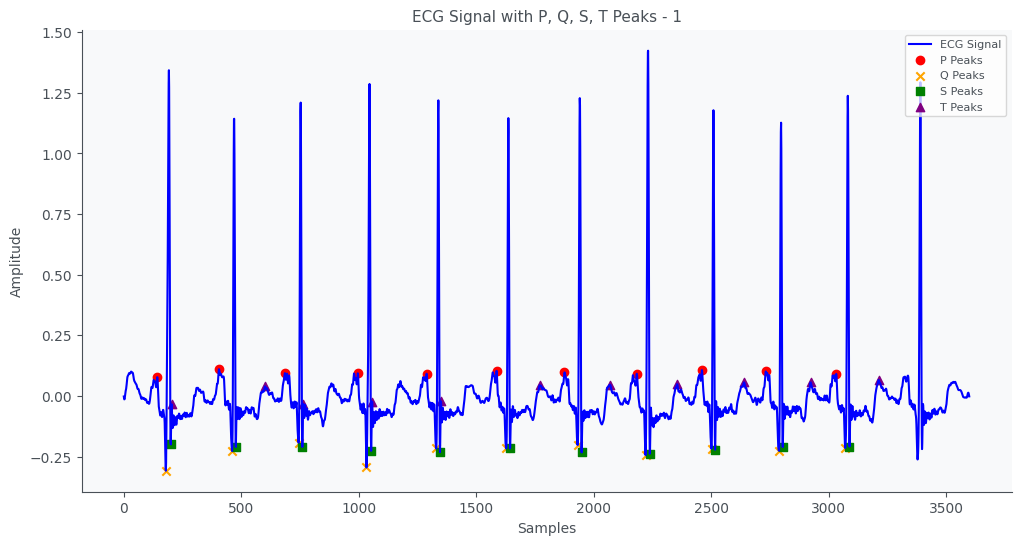

{'pq_interval': np.float64(0.12575757575757576), 'qrs_duration': np.float64(0.04772727272727273), 'st_interval': np.float64(0.2196969696969697), 'p_p_interval_mean': np.float64(0.8030555555555555), 'p_p_interval_std': np.float64(0.04113456538163255), 'qt_interval': np.float64(0.3194444444444444), 'total_beat_duration': np.float64(0.5017676767676768)}


In [31]:
import neurokit2 as nk

def compute_qrs(record_name, show=False):
    try: 
        # record = wfdb.rdrecord(f'{data_path}/{record_name}')
        raw_ecg_signal = all_signals[record_name]
        ecg_signal = nk.ecg_clean(raw_ecg_signal, sampling_rate=frequency, method="biosppy")
        _, waves = nk.ecg_delineate(ecg_signal, rpeaks=None, sampling_rate=frequency, method="peak")
        #print(waves.keys())

        def valid_peaks(peaks):
            """
            Filters out NaN values from the peaks array and ensures the result contains valid integer indices.

            Args:
                peaks (array-like): Array of peak indices, which may include NaN.

            Returns:
                np.ndarray: Array of valid integer indices.
            """
            if peaks is not None:
                # Convert to numpy array and filter out NaN values
                peaks = np.array(peaks)
                peaks = peaks[~np.isnan(peaks)]  # Remove NaN values
                return peaks.astype(int)  # Convert to integers
            return np.array([], dtype=int)  # Return empty array if peaks is None

        p_peaks = valid_peaks(waves['ECG_P_Peaks'])
        t_peaks = valid_peaks(waves['ECG_T_Peaks'])
        s_peaks = valid_peaks(waves['ECG_S_Peaks'])
        q_peaks = valid_peaks(waves['ECG_Q_Peaks'])
        p_onsets = valid_peaks(waves['ECG_P_Onsets'])
        t_offsets = valid_peaks(waves['ECG_T_Offsets'])

        if show:
            # Plot ECG with Peaks
            plt.figure(figsize=(12, 6))
            plt.plot(ecg_signal, label='ECG Signal', color='blue')

            # Plot the detected peaks
            if p_peaks is not None:
                plt.scatter(p_peaks, ecg_signal[p_peaks], color='red', label='P Peaks', marker='o')
            if q_peaks is not None:
                plt.scatter(q_peaks, ecg_signal[q_peaks], color='orange', label='Q Peaks', marker='x')
            if s_peaks is not None:
                plt.scatter(s_peaks, ecg_signal[s_peaks], color='green', label='S Peaks', marker='s')
            if t_peaks is not None:
                plt.scatter(t_peaks, ecg_signal[t_peaks], color='purple', label='T Peaks', marker='^')
          
            # Add labels and legend
            plt.title(f'ECG Signal with P, Q, S, T Peaks - {record_name}')
            plt.xlabel('Samples')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid()
            plt.show()

        features = {}
        
        # 1. Intervals
        if len(p_peaks) > 0 and len(q_peaks) > 0:
            # Find the minimum length between p_peaks and q_peaks
            min_len = min(len(p_peaks), len(q_peaks))
            features['pq_interval'] = np.mean(np.abs(p_peaks[:min_len] - q_peaks[:min_len])) / frequency    

        if len(q_peaks) > 0 and len(s_peaks) > 0:
            min_len = min(len(q_peaks), len(s_peaks))
            features['qrs_duration'] = np.mean(np.abs(s_peaks[:min_len] - q_peaks[:min_len])) / frequency

        if len(s_peaks) > 0 and len(t_peaks) > 0:
            min_len = min(len(s_peaks), len(t_peaks))
            features['st_interval'] = np.mean(np.abs(t_peaks[:min_len] - s_peaks[:min_len])) / frequency
        
        # 2. Rhythm features
        if len(p_peaks) > 1:
            p_p_intervals = np.diff(p_peaks) / frequency
            features['p_p_interval_mean'] = np.mean(p_p_intervals)
            features['p_p_interval_std'] = np.std(p_p_intervals)
        
        # 3. Morphology features
        if len(p_onsets) > 0 and len(t_offsets) > 0:
            min_len = min(len(t_offsets), len(q_peaks))
            features['qt_interval'] = np.mean(np.abs(t_offsets[:min_len] - q_peaks[:min_len])) / frequency
            min_len = min(len(t_offsets), len(p_onsets))
            features['total_beat_duration'] = np.mean(np.abs(t_offsets[:min_len] - p_onsets[:min_len])) / frequency
        
        return features
    except:
        return {
            'pq_interval': np.nan,
            'qrs_duration': np.nan,
            'st_interval': np.nan,
            'p_p_interval_mean': np.nan,
            'p_p_interval_std': np.nan,
            'qt_interval': np.nan,
            'total_beat_duration': np.nan
        }

record_name = 1
qrs_durations = compute_qrs(record_name, show=True)
print(qrs_durations)



In [32]:
from scipy.stats import kurtosis

# Create a reusable function for Pan-Tompkins algorithm
def compute_pan_tompkins(record_name):
    ecg_signal = all_signals[record_name]
    out = ecg.ecg(signal=ecg_signal, sampling_rate=frequency, show=False)

    filtered_ecg = out['filtered']
    r_peaks = out['rpeaks']
    heart_rate = out['heart_rate']

    # convert r_peaks to seconds
    r_peaks_seconds = r_peaks / frequency

    # Compute RR intervals
    rr_intervals = np.diff(r_peaks_seconds)

    # Compute mean and std of the RR intervals
    rr_mean = np.mean(rr_intervals)
    rr_std = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(r_peaks_seconds))))
    rr_kurtosis = kurtosis(rr_intervals)

    # RR intervals falling in the lower 5% and higher 5% tails of their frequency distribution.
    lower_tail = np.percentile(rr_intervals, 5)
    upper_tail = np.percentile(rr_intervals, 95)


    # compute for second order rr intervals
    second_order_rr_intervals = np.diff(rr_intervals)
    second_order_rr_mean = np.mean(second_order_rr_intervals)
    second_order_rr_std = np.std(second_order_rr_intervals)

    # We computed the average power in very low frequency (VLF) = 0-0.04 Hz, low frequency (LF)= 0.04-0.15 Hz, high frequency (HF)= 0.15-0.5 Hz, and a ratio of LF to HF. Among these features, VLF provided the strongest discriminative power.  
    vlf_power = np.mean(filtered_ecg[0:int(0.04 * frequency)])
    lf_power = np.mean(filtered_ecg[int(0.04 * frequency):int(0.15 * frequency)])
    hf_power = np.mean(filtered_ecg[int(0.15 * frequency):int(0.5 * frequency)])
    lf_hf_ratio = lf_power / hf_power

    # Compute heart rate features
    if len(heart_rate) > 0:
        hr_mean = np.mean(heart_rate)
        hr_std = np.std(heart_rate)
        min_hr = np.min(heart_rate)
        max_hr = np.max(heart_rate)
    else:
        hr_mean = np.nan
        hr_std = np.nan
        min_hr = np.nan
        max_hr = np.nan

    # compute signal features
    signal_power = np.sum(np.square(filtered_ecg))
    signal_entropy = -np.sum(np.square(filtered_ecg) * np.log2(np.square(filtered_ecg)))
    signal_energy = np.sum(np.square(filtered_ecg))
    signal_power = signal_power / len(filtered_ecg)

    # compute pNN50
    pnn50 = np.sum(np.abs(np.diff(r_peaks_seconds)) <= 0.5) / (len(r_peaks_seconds)-1) * 100

    # irregularity features
    irregularity_mean = np.mean(np.diff(r_peaks_seconds))
    irregularity_std = np.std(np.diff(r_peaks_seconds))
    rr_coefficient = np.std(rr_intervals) / np.mean(rr_intervals)

    # add the qrs duation features
    qrs_features = compute_qrs(record_name)

    features = {
        'rr_mean': rr_mean,
        'rr_std': rr_std,
        'rmssd': rmssd,
        'rr_kurtosis': rr_kurtosis,
        'lower_tail': lower_tail,
        'upper_tail': upper_tail,
        'vlf_power': vlf_power,
        'lf_power': lf_power,
        'hf_power': hf_power,
        'lf_hf_ratio': lf_hf_ratio,
        'second_order_rr_intervals': second_order_rr_intervals,
        'second_order_rr_mean': second_order_rr_mean,
        'second_order_rr_std': second_order_rr_std,        
        'hr_mean': hr_mean,
        'hr_std': hr_std,
        'min_hr': min_hr,
        'max_hr': max_hr,
        'pnn50': pnn50,
        'signal_power': signal_power,
        'signal_energy': signal_energy,
        'signal_entropy': signal_entropy,
        'irregularity_mean': irregularity_mean,
        'irregularity_std': irregularity_std,
        'rr_coefficient': rr_coefficient,
        **qrs_features
    }

    return features

# Test the function with a single record
record_name = 1
features = compute_pan_tompkins(record_name)
print(features)


{'rr_mean': np.float64(0.8078282828282828), 'rr_std': np.float64(0.02661237586401538), 'rmssd': np.float64(0.808266511174637), 'rr_kurtosis': np.float64(-0.8187715295551521), 'lower_tail': np.float64(0.7722222222222221), 'upper_tail': np.float64(0.8513888888888883), 'vlf_power': np.float64(0.013665214073287952), 'lf_power': np.float64(0.08102778465894371), 'hf_power': np.float64(-0.014626316127940572), 'lf_hf_ratio': np.float64(-5.539862802784413), 'second_order_rr_intervals': array([ 1.38888889e-02,  2.77777778e-02,  4.44089210e-16,  1.38888889e-02,
        1.66666667e-02, -3.61111111e-02, -3.61111111e-02,  2.77777778e-02,
       -1.11111111e-02,  6.94444444e-02]), 'second_order_rr_mean': np.float64(0.008611111111111024), 'second_order_rr_std': np.float64(0.030032132996935978), 'hr_mean': np.float64(74.35299569624543), 'hr_std': np.float64(1.659413501644823), 'min_hr': np.float64(71.95405442362915), 'max_hr': np.float64(77.24025726415334), 'pnn50': np.float64(0.0), 'signal_power': np.

In [33]:
print(df.columns)


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '3591', '3592', '3593', '3594', '3595', '3596', '3597', '3598', '3599',
       'label'],
      dtype='object', length=3601)


In [34]:
# Process all the records
all_features = []
for i, record_name in enumerate(df.index):
    features = compute_pan_tompkins(record_name)
    # include the record name and label
    features['record_name'] = record_name
    features['label'] = df.iloc[record_name].label
    all_features.append(features)
    if i % 100 == 0:
        print(f'Processed {i} records')
        features_df = pd.DataFrame(all_features)
        features_df.to_csv('results/mit_bih_pan_tompkins_features.csv', index=False)
# Convert to DataFrame
features_df = pd.DataFrame(all_features)
features_df.to_csv('results/mit_bih_pan_tompkins_features.csv', index=False)

Processed 0 records
Processed 100 records
Processed 200 records
Processed 300 records
Processed 400 records
